In [1]:
'''
main 함수에서는 한가지 종목 구매 판단 기준으로 작성(예시)
여러 종목 딥러닝 학습과 레포트 작성 가능, 구매 판단은 첫번째 종목 기준으로만 판단
'''
from google.colab import drive
drive.mount('/content/drive')
import requests #외부 api 호출
import pandas as pd #데이터 구조, 가공
import yfinance as yf #yahoo finance 데이터 수집
from datetime import datetime #날짜 시간처리
import json
from openai import OpenAI
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
)
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt #그래프 그리기
import matplotlib.dates as mdates #날짜 축
from google.colab import userdata
from datetime import datetime, date, timedelta
import os

# 파일 저장될 주소
folder_path = "/content/drive/MyDrive"
print("현재 파일 저장 주소 : " + folder_path)

Mounted at /content/drive
현재 파일 저장 주소 : /content/drive/MyDrive


In [2]:
api_key = userdata.get('FRED_API_KEY')
# FRED에서 제공하는 지표 코드와 명칭
fred_indicators = {
    'T10YIE': '10년 기대 인플레이션율',  # 10년 만기 기대 인플레이션율 (일간)
    'T10Y2Y': '장단기 금리차',  # 10년-2년 국채 수익률 스프레드 (일간)
    'FEDFUNDS': '기준금리',  # 연방기금 금리 (월간)
    'UMCSENT': '미시간대 소비자 심리지수',  # 소비자 신뢰 지수 (월간)
    'UNRATE': '실업률',  # 실업률 (월간)
    'USREC': '경기침체',  # 경기침체 지수 (월간) --> 장단기 금리차를 통해 확인 가능.
    'DGS2': '2년 만기 미국 국채 수익률',  # 2년 만기 국채 수익률 (일간)
    'DGS10': '10년 만기 미국 국채 수익률',  # 10년 만기 국채 수익률 (일간)

    # 추가 지표
    'STLFSI4': '금융스트레스지수',  # 금융 스트레스 지수 (주간)
    #'PCE': '개인 소비 지출',  # 개인 소비 지출 (월간) -> 소비자물가지수(CPI)나 GDP, 실업률, 인플레이션 기대 등 다른 핵심 지표가 이미 전반적 경기 상황을 반영.
    'INDPRO': '산업생산',  # 산업 생산 지수 (월간)
    #'HOUST': '주택 착공',  # 신규 주택 착공 건수 (월간)
    #'UNEMPLOY': '실업자수',  # 실업자의 총 수 (월간)
    'RSAFS': '소매판매',  # 소매판매 지수 (월간)
    'CPIENGSL': '에너지 가격 지수',  # 소비자 물가지수 중 에너지 부문 (월간) -> 소비자물가지수(CPI)나 GDP, 실업률, 인플레이션 기대 등 다른 핵심 지표가 이미 전반적 경기 상황을 반영.
    'AHETPI': '임금 성장률',  # 시간당 평균 임금 성장률 (월간)
    #'PPIACO': '농산물 가격 지수',  # 생산자 물가지수 중 농산물 부문 (월간)
    'CPIAUCSL': '소비자 물가지수',  # 전체 소비자 물가지수 (월간)
    #'CSUSHPINSA': '주택가격지수',  # 케이스-실러 주택 가격 지수 (월간) -> 5년 변동금리 모기지 (MORTGAGE5US): 부동산 시장이 대상 종목(빅테크) 주가 변동에 단기적으로 큰 영향 미치는지 불분명. 단기간(1주일 후) 예측에서는 영향력 제한적.
    #'MORTGAGE30US': '30년 고정금리 모기지',  # 30년 만기 고정금리 모기지 금리 (주간)
    #'MORTGAGE15US': '15년 고정금리 모기지',  # 15년 만기 고정금리 모기지 금리 (주간)
    'MORTGAGE5US': '5년 변동금리 모기지',  # 5년 변동금리 모기지 금리 (주간)
    'DTWEXM': '미국 달러 환율',  # 미국 무역가중 환율 (월간)
    'M2': '통화 공급량 M2',  # M2 통화 공급량 (주간) -> FEDFUNDS나 금리 동향, 달러 인덱스, 금융스트레스지수가 이미 유동성 상황을 대략 파악 가능.
    #'TEDRATE': 'TED 스프레드',  # 3개월 만기 미국 국채와 유로달러 금리 스프레드 (일간) -> FEDFUNDS나 금리 동향, 달러 인덱스, 금융스트레스지수가 이미 유동성 상황을 대략 파악 가능.
    'BAMLH0A0HYM2': '미국 하이일드 채권 스프레드',  # 미국 하이일드 채권과 국채 스프레드 (일간) -> 금융시장 신용위험을 반영하지만, 이미 금융스트레스지수(STLFSI4), 장단기금리차, VIX 등의 지표로 대략적인 위험 선호도나 스트레스 상황 파악 가능.
    'BAMLC0A0CM': '미국 회사채 스프레드',  # 미국 회사채와 국채 스프레드 (일간)
    'BAMLCC0A0CMTRIV': '미국 회사채 수익률',  # 미국 회사채 수익률 (일간)
    #'BAMLCC0A1AAATRIV': '미국 회사채 AAA등급 수익률',  # AAA등급 회사채 수익률 (일간)
    'BAMLCC0A4BBBTRIV': '미국 회사채 BBB등급 수익률',  # BBB등급 회사채 수익률 (일간)
    'BAMLHYH0A0HYM2TRIV': '미국 하이일드 채권 수익률',  # 하이일드 채권 수익률 (일간)
    'BAMLHYH0A3CMTRIV': '미국 하이일드 채권 CCC등급 수익률',  # CCC등급 하이일드 채권 수익률 (일간)
    #'BAMLHE00EHYIEY': '미국 하이일드 채권 기대수익률',  # 하이일드 채권 기대수익률 (일간)
    'TDSP': '가계 부채 비율',  # 가계의 부채 상환 비율을 나타냄 (분기)
    #'A939RX0Q048SBEA': '실질 GDP 성장률',  # 계절 조정된 연간 실질 GDP 성장률 (분기)
    'GDPC1': 'GDP 성장률',  # 실질 국내총생산 성장률, 물가 조정을 반영 (분기)
    #'W019RCQ027SBEA': '정부 지출',  # 정부의 총 지출 금액 (분기)
    #'DRBLACBS': '대출 연체율',  # 기업 대출의 연체율 (분기)

    # 주식시장 관련 추가 지표
    'DJIA': '다우존스 산업평균지수',  # 미국 대형 30개 기업의 주가 평균 (일간)
    'NASDAQCOM': '나스닥 종합지수'  # 나스닥 시장 전체 종합 주가 지수 (일간)
}

yfinance_indicators = {
    #'S&P 500 지수': '^GSPC',    # S&P 500 지수: 미국 주식 시장의 대형주 500개로 구성된 지수로, 전체 시장의 대표 지표입니다.
    #'금 가격': 'GC=F',           # 금 가격 (선물): 시장의 안전자산 선호도를 나타내며, 인플레이션 및 경제 불확실성에 민감합니다.
    #'달러 인덱스': 'DX-Y.NYB',    # 달러 인덱스: 미국 달러의 글로벌 통화 대비 상대적 가치를 나타냅니다.

    # 추가 지표
    '나스닥 100': '^NDX',           # 나스닥 100 지수: 나스닥 상장 대형 기술주 100개를 포함하며, 기술주 중심의 시장 흐름을 반영합니다.
    #'S&P 500 ETF': 'SPY',           # S&P 500 추종 ETF: S&P 500 지수를 추종하는 상장지수펀드로, 시장 전체의 동향을 추적합니다.
    #'QQQ ETF': 'QQQ',               # 나스닥 100 추종 ETF: 기술주 중심의 나스닥 100 지수를 추종하는 ETF입니다.
    #'러셀 2000 ETF': 'IWM',         # 러셀 2000 추종 ETF: 중소형주로 구성된 러셀 2000 지수를 추종하며, 경제 성장성을 반영합니다.
    #'다우 존스 ETF': 'DIA',         # 다우 존스 추종 ETF: 다우존스 산업평균지수를 추종하며, 안정적인 대형주의 흐름을 나타냅니다.
    'NYSE FANG+ 지수': '^NYFANG',   # NYSE FANG+ 지수
    'VIX 지수': '^VIX'              # ^VIX (변동성 지수, 공포 지수): 시장의 변동성 기대치를 반영하며, 투자 심리를 측정하는 지표입니다.
}

# 나스닥 100 상위 종목 티커 리스트와 한글 이름
nasdaq_top_100 = [
    ("AAPL", "애플"), ("MSFT", "마이크로소프트"), ("AMZN", "아마존"), ("GOOGL", "구글 A"),
    ("GOOG", "구글 C"), ("META", "메타"), ("TSLA", "테슬라"), ("NVDA", "엔비디아"), ("PYPL", "페이팔"),
    ("ADBE", "어도비"), ("NFLX", "넷플릭스")

    , ("CMCSA", "컴캐스트"), ("PEP", "펩시코"),
    ("INTC", "인텔"), ("CSCO", "시스코"), ("AVGO", "브로드컴"), ("TXN", "텍사스 인스트루먼트"),
    ("QCOM", "퀄컴"), ("COST", "코스트코"), ("AMGN", "암젠")

    , ("CHTR", "차터 커뮤니케이션"),
    ("SBUX", "스타벅스"), ("AMD", "AMD")
    , ("MDLZ", "몬델리즈"), ("INTU", "인트윗"),
    ("ISRG", "인튜이티브 서지컬"), ("BKNG", "부킹홀딩스"), ("ADP", "ADP"),
    ("VRTX", "버텍스"), ("MU", "마이크론"), ("AMAT", "어플라이드 머티리얼즈"), ("REGN", "리제네론"),
    ("LRCX", "램 리서치"), ("KDP", "케우리그 닥터페퍼"),
    ("FISV.VI", "피서브"),
    ("CSX", "CSX"),
    ("GILD", "길리어드 사이언스"), ("MELI", "메르카도 리브레"), ("SNPS", "시놉시스"),
    ("EA", "일렉트로닉 아츠")

    , ("KLAC", "KLA"), ("ADSK", "오토데스크"), ("CTAS", "신타스"),
    ("XEL", "엑셀 에너지"), ("PANW", "팔로알토 네트웍스"), ("ANSS", "앤시스"), ("TEAM", "아틀라시안"),
    ("WDAY", "워크데이"), ("ILMN", "일루미나"), ("DOCU", "도큐사인"),
    ("MRNA", "모더나"), ("IDXX", "아이덱스"), ("ZM", "줌 비디오"), ("DXCM", "덱스컴"),
    ("ROST", "로스 스토어스"), ("CRWD", "크라우드스트라이크"), ("MAR", "메리어트"),
    ("EXC", "엑셀론"), ("MNST", "몬스터 비버리지"), ("PCAR", "PACCAR"), ("LCID", "루시드 모터스"),
    ("ALGN", "얼라인 테크놀로지"), ("BIIB", "바이오젠"),
    ("MTCH", "매치 그룹"), ("OKTA", "옥타"), ("BKR", "베이커 휴즈"), ("ZS", "지스케일러"),
    ("CDNS", "케이던스"), ("CPRT", "코파트"), ("FAST", "패스트널"), ("AEP", "아메리칸 일렉트릭"),
    ("ORLY", "오라일리"), ("VRSK", "버리스크"), ("CTSH", "코그니전트"), ("PDD", "핀둬둬"),
    ("CHKP", "체크포인트"), ("JD", "징둥"), ("NTES", "넷이즈"), ("KHC", "크래프트 하인즈"),
    ("DLTR", "달러 트리"), ("EPAM", "EPAM 시스템즈"), ("SWKS", "스카이웍스"),
    ("NXPI", "NXP 반도체"), ("TTD", "트레이드 데스크"),
    ("PAYX", "페이첵스"), ("BIDU", "바이두"), ("WDC", "웨스턴 디지털"), ("TRMB", "트림블"),
    ("FTNT", "포티넷"), ("VRSN", "베리사인"), ("ASML", "ASML 홀딩"), ("BMRN", "바이오마린"),
    ("LULU", "룰루레몬"), ("EBAY", "이베이"), ("CEG", "컨스텔레이션 에너지"), ("RIVN", "리비안")
]

#수집할 날짜
start_date = '2006-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

fred_data_frames = []
for code, name in fred_indicators.items():

    # 지표별 제공 주기에 따른 요청 주기 설정
    if code in ['FEDFUNDS', 'UMCSENT', 'UNRATE', 'USREC', 'PCE', 'INDPRO',
                'HOUST', 'UNEMPLOY', 'RSAFS', 'CPIENGSL', 'AHETPI', 'PPIACO', 'CPIAUCSL',
                'CSUSHPINSA', 'DTWEXM']:
        frequency = 'm'
    elif code in ['STLFSI4', 'M2', 'MORTGAGE30US', 'MORTGAGE15US', 'MORTGAGE5US']:
        frequency = 'w'
    elif code in ['TDSP', 'A939RX0Q048SBEA', 'GDPC1', 'W019RCQ027SBEA', 'DRBLACBS']:
        frequency = 'q'
    else:
        frequency = 'd'


    url = f'https://api.stlouisfed.org/fred/series/observations'

    params = {
        'series_id': code,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date,
        'frequency': frequency
    }
    response = requests.get(url, params=params)


    if response.status_code == 200:
        data = response.json().get('observations', [])
        if data:
            df = pd.DataFrame(data)[['date', 'value']]
            df.columns = ['date', name]
            df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)  #타임존 제거
            fred_data_frames.append(df.set_index('date'))
        else:
            print(f"No data found for indicator {name} ({code}).")
    else:
        print(f"Failed to fetch data for indicator {name} ({code}): {response.status_code}")


    #데이터 빈도에 따른 리샘플링 처리

for i, df in enumerate(fred_data_frames):
    if df.empty: #아얘 없을때
        print(f"DataFrame {i} is empty, skipping resampling.")
        continue
    try:
        inferred_freq = df.index.inferred_freq #데이터 빈도 확인
        # 빈도에 따라 일간 데이터로 변환
        if inferred_freq in ['M', 'MS']:  # 월간 데이터
            fred_data_frames[i] = df.resample('D').ffill() #ffill 이전 날짜에서 채우기
        elif inferred_freq in ['W', 'W-FRI']:  # 주간 데이터
            fred_data_frames[i] = df.resample('D').ffill()
        elif inferred_freq in ['Q', 'QS-OCT']:  # 분기 데이터
            fred_data_frames[i] = df.resample('D').ffill()
        elif inferred_freq in ['B']:  # 영업일 데이터
            fred_data_frames[i] = df.resample('D').ffill()
        # else:
        #     print(f"Unknown frequency for DataFrame {i}: {inferred_freq}")
        else:
            fred_data_frames[i] = df.resample('D').ffill()
    except Exception as e:
        print(f"Error processing DataFrame {i}: {e}")
'''
    print(fred_data_frames)
    #리샘플링 후 저장 (테스트)
    if fred_data_frames:
        merged_df = pd.concat(fred_data_frames, axis=1)

        merged_df.to_csv('fred_data.csv',index=True,encoding='utf-8-sig')
        print("데이터가 'fred_data.csv' 파일로 저장되었습니다.")
    else:
        print("저장할 데이터가 없습니다.")

'''

# yfinance를 통한 데이터 수집
yfinance_data_frames = []
for name, ticker in yfinance_indicators.items():
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    if not df.empty:
        # df = df[['Close']].rename(columns={'Close': name})
        # name만 사용하여 컬럼 이름 지정
        df = df[['Close']]
        df.columns = [name]  # rename 대신 직접 columns 할당
        df.index = df.index.tz_localize(None)
        yfinance_data_frames.append(df)
    else:
        print(f"No data found for indicator {name} ({ticker}).")



'''
#print(yfinance_data_frames)

#(테스트)
if yfinance_data_frames:
    merged_df = pd.concat(yfinance_data_frames, axis=1)

    merged_df.to_csv('fred_data_yf.csv',index=True,encoding='utf-8-sig')
    print("데이터가 'fred_data_yf.csv' 파일로 저장되었습니다.")
else:
    print("저장할 데이터가 없습니다.")

'''

# 나스닥 100 상위 종목 데이터 수집
nasdaq_data_frames = []
for ticker, name in nasdaq_top_100:
    try:
        df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
        if not df.empty:
            #df = df[['Close']].rename(columns={'Close': f"{name}"})
            df = df[['Close']] #시가(Open) 고가(High) 저가(Low) 종가(Close) 조정종가(Adj Close) 거래량(Volume) 값중 종가만
            df.columns = [name]  # rename 대신 직접 columns 할당
            df.index = df.index.tz_localize(None)
            nasdaq_data_frames.append(df)
    except Exception as e:
        print(f"Error downloading data for {ticker} ({name}): {e}")


'''
#print(yfinance_data_frames)

#(테스트)
if nasdaq_data_frames:
    merged_df = pd.concat(nasdaq_data_frames, axis=1)

    merged_df.to_csv('fred_data_yf_stock.csv',index=True,encoding='utf-8-sig')
    print("데이터가 'fred_data_yf_stock.csv' 파일로 저장되었습니다.")
else:
    print("저장할 데이터가 없습니다.")
'''

# 모든 데이터를 날짜 기준으로 외부 결합하여 하나의 데이터프레임으로 결합
all_data_frames = fred_data_frames + yfinance_data_frames + nasdaq_data_frames
if all_data_frames:
    # 결합
    result_df = pd.concat(all_data_frames, axis=1, join='outer')  # 외부 결합으로 누락된 날짜 보완

    # 결측치 및 비정상적인 값 처리
    result_df.replace('.', pd.NA, inplace=True)  # '.'을 NaN으로 변환
    # result_df = result_df.dropna(subset=['10년 기대 인플레이션율', '장단기 금리차', '금융스트레스지수', '5년 변동금리 모기지'], how='any')  # 해당 열에서 NaN 제거
    result_df = result_df.dropna(subset=['10년 기대 인플레이션율', '장단기 금리차'], how='any')  # 해당 열에서 NaN 제거

    # 결측치를 이전 값으로 채움
    result_df.sort_index(inplace=True)
    result_df.ffill(inplace=True)

    # 특정 열에서 결측치가 있는 행 제거
    # result_df = result_df.dropna(subset=['S&P 500 지수'])

    # CSV 파일로 저장
    try:
        result_df.to_csv(folder_path + '/total.csv', index_label="날짜", encoding='utf-8-sig')
        print(f"Data saved to {folder_path}")
    except PermissionError:
        # 현재 시간을 파일명에 추가하여 새로운 파일 생성
        # from datetime import datetime
        # timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        # folder_path = f'total_{timestamp}.csv'
        result_df.to_csv(folder_path + '/total.csv', index_label="날짜", encoding='utf-8-sig')
        print(f"Permission denied for original file. Data saved to {folder_path}")
else:
    print("No data collected for any indicators.")



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Data saved to /content/drive/MyDrive


In [3]:
# 설정 값
STOCK_SYMBOL = "GOOGL"
NEWS_COUNT = 20  # 원하는 뉴스 개수 설정

def get_news_summary(content_item):
    return content_item.get('summary', '콘텐츠 없음')

# JSON 데이터 구조 생성
news_data = []

# 뉴스 데이터 가져오기
dat = yf.Ticker(STOCK_SYMBOL)
news_items = dat.get_news(count=NEWS_COUNT)  # count 파라미터 추가

for item in news_items:
    content = item['content']
    news_entry = {
        "stock": STOCK_SYMBOL,
        "date": content['pubDate'],
        "title": content['title'],
        "provider": content['provider'].get('displayName', '알 수 없음'),
        "summary": get_news_summary(content)
    }
    news_data.append(news_entry)

    # 콘솔 출력
    print(f"[{news_entry['date']}] {news_entry['title']}")
    print(f"출처: {news_entry['provider']}")
    print(f"내용: {news_entry['summary'][:100]}...\n{'-'*50}")

# JSON 파일 저장
with open(folder_path + f'/{STOCK_SYMBOL}_news.json', 'w', encoding='utf-8') as f:
    json.dump(news_data, f, ensure_ascii=False, indent=2)

print(f"{STOCK_SYMBOL} 관련 최신 {NEWS_COUNT}개 뉴스가 저장되었습니다.")

[2025-03-25T10:00:13Z] Tech stock momentum is hiding behind the cloud of tariffs: Morning Brief
출처: Yahoo Finance
내용: The next phase of the tech trade follows reset expectations with more modest valuations....
--------------------------------------------------
[2025-03-24T23:30:00Z] Mag 7 takes on 'growth as defensive' bias, strategist says
출처: Yahoo Finance Video
내용: Citi head of US equity strategy Scott Chronert joins Market Domination hosts Julie Hyman and Josh Li...
--------------------------------------------------
[2025-03-25T11:55:18Z] How Alphabet Cybersecurity Acquisition Raises Big Questions. Is Google Stock A Buy Or Sell?
출처: Investor's Business Daily
내용: When Alphabet agreed to buy fast growing cybersecurity firm Wiz in an all-cash $32 billion deal, inv...
--------------------------------------------------
[2025-03-25T11:01:28Z] Alphabet's Waymo aims for 2026 self-driving ride-hailing launch in Washington, D.C
출처: Reuters
내용: Alphabet's self-driving unit Waymo said on Tuesd

In [4]:
# 데이터 다운로드 종료 날짜를 이전 거래일로 설정
end_date = date.today() - timedelta(days=1)
end_date_str = end_date.strftime('%Y-%m-%d')
start_date_ma = end_date - pd.Timedelta(days=60)

# 3. 가져올 티커(심볼) 지정
STOCK_SYMBOL = "GOOGL"

df = yf.download(STOCK_SYMBOL, start=start_date_ma, end=end_date)

if df.empty:
    print(f"오류: {end_date_str}의 GOOGL 주가 데이터를 다운로드하지 못했습니다. 나중에 다시 시도하세요.")
else:
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()

    # 이동평균선 값이 NaN이 아닌지 확인
    if pd.notna(df['MA_5'].iloc[-1]) and pd.notna(df['MA_20'].iloc[-1]):
        try:
            recent_ma_5 = float(df['MA_5'].iloc[-1])
            recent_ma_20 = float(df['MA_20'].iloc[-1])
            recent_close_price = float(df['Close'].iloc[-1])

            # JSON 형태로 저장할 데이터 구성
            technical_indicators_data = {
                "Stock": STOCK_SYMBOL,
                "Recent_Close_Price": recent_close_price,
                "MA_5": recent_ma_5,
                "MA_20": recent_ma_20,
                "Date": end_date_str
            }

            # JSON 파일 이름 생성 (이전 거래일로 변경)
            filename = f"{STOCK_SYMBOL}_Moving_Average.json"
            file_path = os.path.join(folder_path, filename)

            with open(file_path, 'w') as f:
                json.dump(technical_indicators_data, f, indent=4)
            print(f"'{filename}' 저장 완료")
        except TypeError as e:
            print(f"JSON 직렬화 오류 발생 (TypeError): {e}")
        except Exception as e:
            print(f"'{filename}' 저장 실패: {e}")
    else:
        print(f"오류: 이동평균선 값을 계산할 수 없습니다. 데이터가 부족하거나 NaN 값을 포함하고 있습니다.")

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True
'GOOGL_Moving_Average.json' 저장 완료



<ipython-input-4-f21400e6156b>:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  recent_close_price = float(df['Close'].iloc[-1])


In [5]:
STOCK_SYMBOL = 'GOOGL'

ticker = yf.Ticker(STOCK_SYMBOL)

info_columns_mapper = {
    'market': 'market',
    'sector': 'sector',
    'industry': 'industry',
    'recommendationKey': 'recommendationKey',
    'sharesOutstanding': 'sharesOutstanding',
    'averageVolume10days': 'averageVolume10days',
    'averageVolume': 'averageVolume',
    'heldPercentInstitutions': 'heldPercentInstitutions',
    'shortRatio': 'shortRatio',
    'sharesPercentSharesOut': 'sharesPercentSharesOut',
    'shortPercentOfFloat': 'shortPercentOfFloat',
    'marketCap': 'marketCap',
    'currentPrice': 'currentPrice',
    'fiftyDayAverage': 'fiftyDayAverage',
    'twoHundredDayAverage': 'twoHundredDayAverage',
    'fiftyTwoWeekHigh': 'fiftyTwoWeekHigh',
    'fiftyTwoWeekLow': 'fiftyTwoWeekLow',
    'SandP52WeekChange': 'SandP52WeekChange',
    '52WeekChange': '52WeekChange',
    'ytdReturn': 'ytdReturn',
    'fiveYearAverageReturn': 'fiveYearAverageReturn',
    'beta': 'beta',
    'totalRevenue': 'totalRevenue',
    'grossProfits': 'grossProfits',
    'revenuePerShare': 'revenuePerShare',
    'ebitda': 'ebitda',
    'ebitdaMargins': 'ebitdaMargins',
    'debtToEquity': 'debtToEquity',
    'operatingCashflow': 'operatingCashflow',
    'freeCashflow': 'freeCashflow',
    'totalCashPerShare': 'totalCashPerShare',
    'currentRatio': 'currentRatio',
    'quickRatio': 'quickRatio',
    'returnOnAssets': 'returnOnAssets',
    'returnOnEquity': 'returnOnEquity',
    'grossMargins': 'grossMargins',
    'operatingMargins': 'operatingMargins',
    'profitMargins': 'profitMargins',
    'totalCash': 'totalCash',
    'totalDebt': 'totalDebt',
    'priceToBook': 'priceToBook',
    'enterpriseValue': 'enterpriseValue',
    'enterpriseToRevenue': 'enterpriseToRevenue',
    'enterpriseToEbitda': 'enterpriseToEbitda',
    'forwardEps': 'forwardEps',
    'trailingEps': 'trailingEps',
    'priceToSalesTrailing12Months': 'priceToSalesTrailing12Months',
    'forwardPE': 'forwardPE',
    'trailingPE': 'trailingPE',
    'dividendYield': 'dividendYield',
    'payoutRatio': 'payoutRatio',
    'trailingAnnualDividendYield': 'trailingAnnualDividendYield',
    'dividendRate': 'dividendRate',
    'trailingAnnualDividendRate': 'trailingAnnualDividendRate',
    'revenueGrowth': 'revenueGrowth',
    'earningsGrowth': 'earningsGrowth',
    'earningsQuarterlyGrowth': 'earningsQuarterlyGrowth',
    'revenueQuarterlyGrowth': 'revenueQuarterlyGrowth',
    'heldPercentInsiders': 'heldPercentInsiders',
}

financial_columns_mapper = {
    'Research Development': 'ResearchDevelopment',
    'Net Income': 'NetIncome',
    'Gross Profit': 'GrossProfit',
    'Operating Income': 'OperatingIncome',
    'Total Revenue': 'TotalRevenue',
    'Cost Of Revenue': 'CostOfRevenue',
}

balance_sheet_columns_mapper = {
    'Total Liab': 'TotalLiab',
    'Total Stockholder Equity': 'TotalStockholderEquity',
    'Total Assets': 'TotalAssets',
}

raw_info = ticker.info
info_dict = {}

# info 정보 추가
for info_column, english_name in info_columns_mapper.items():
    info_dict[english_name] = raw_info.get(info_column)

# ticker.financials : 직전 4년 매출관련 데이터 추가
financial_dict = ticker.financials.T.to_dict('list')
financial_data = {}
for financial_column, english_name in financial_columns_mapper.items():
    financial_data["list_financial_" + english_name] = list(reversed(financial_dict.get(financial_column, [])))
info_dict.update(financial_data)

# ticker.balance_sheet : 직전 4년 재무상태 데이터 추가
balance_sheet_dict = ticker.balance_sheet.T.to_dict('list')
balance_sheet_data = {}
for balance_sheet_column, english_name in balance_sheet_columns_mapper.items():
    balance_sheet_data["list_balancesheet_" + english_name] = list(reversed(balance_sheet_dict.get(balance_sheet_column, [])))
info_dict.update(balance_sheet_data)

# JSON으로 저장
with open(folder_path + '/' + STOCK_SYMBOL + "_info.json", "w", encoding="utf-8") as f:
    json.dump(info_dict, f, indent=4)

print(STOCK_SYMBOL + " 데이터가 " + STOCK_SYMBOL + "_info.json 파일로 저장되었습니다.")

GOOGL 데이터가 GOOGL_info.json 파일로 저장되었습니다.


Loading data...
Handling missing values and filtering invalid data...
Scaling data...


<ipython-input-10-72f175deac97>:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-10-72f175deac97>:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


Building Transformer model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 90, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 90, 30)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_8    │ (None, 90, 1)          │             57 │ input_layer_2[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_12   │ (None, 90, 30)         │         29,550 │ input_layer_3[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_26 (Dropout)      │ (None, 90, 1)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_38 (Dropout)      │ (None, 90, 30)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_17 (Add)              │ (None, 90, 1)          │              0 │ input_layer_2[0][0],   │
│                           │                        │                │ dropout_26[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_25 (Add)              │ (None, 90, 30)         │              0 │ input_layer_3[0][0],   │
│                           │                        │                │ dropout_38[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_16    │ (None, 90, 1)          │              2 │ add_17[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_24    │ (None, 90, 30)         │             60 │ add_25[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 90, 256)        │            512 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 90, 256)        │          7,936 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 90, 1)          │            257 │ dense_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_30 (Dense)          │ (None, 90, 30)         │          7,710 │ dense_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_27 (Dropout)      │ (None, 90, 1)          │              0 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_39 (Dropout) 

 Total params: 195,145 (762.29 KB)

 Trainable params: 195,145 (762.29 KB)

 Non-trainable params: 0 (0.00 B)

Training model...
Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 69s 108ms/step - loss: 0.0167 - mae: 0.0756
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0011 - mae: 0.0247
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0010 - mae: 0.0236
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 8.3312e-04 - mae: 0.0212
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 8.1734e-04 - mae: 0.0209
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 7.9386e-04 - mae: 0.0200
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 6.5046e-04 - mae: 0.0179
Epoch 8/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 6.2990e-04 - mae: 0.0177
Epoch 9/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 6.0669e-04 - mae: 0.0171
Epoch 10/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 5.8421e-04 - mae: 0.0165
Epoch 11/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 5.6404e-04 - mae: 0.0161
Epoch 12/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 

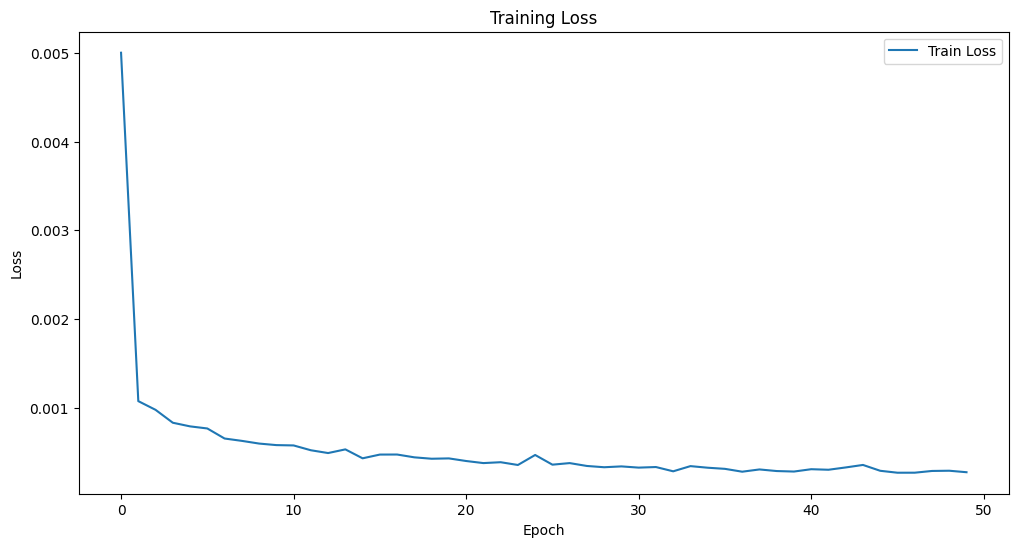

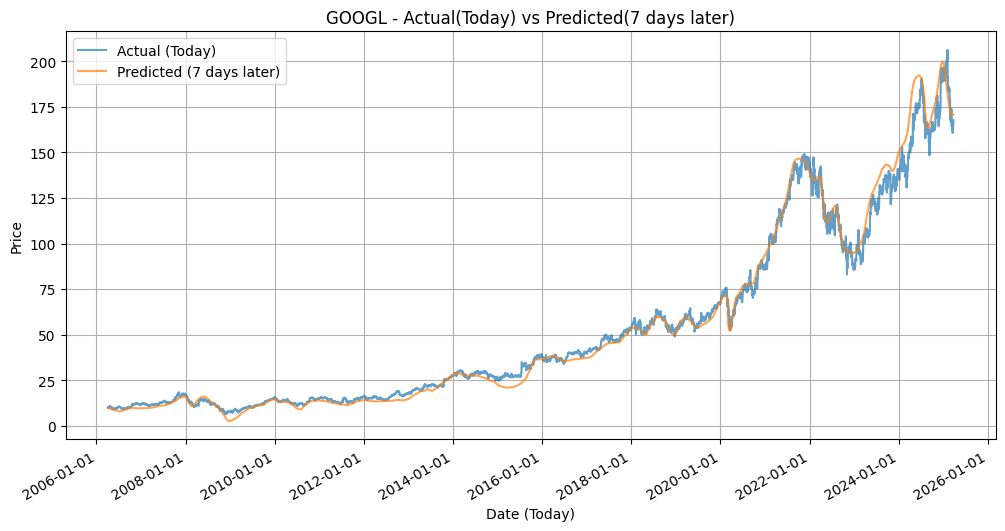

In [10]:
# Transformer Encoder 정의
def transformer_encoder(inputs, num_heads, ff_dim, dropout=0.1):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    ffn = Dense(ff_dim, activation="relu")(attention_output)
    ffn = Dense(inputs.shape[-1])(ffn)
    ffn_output = Dropout(dropout)(ffn)
    ffn_output = Add()([attention_output, ffn_output])
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)

    return ffn_output

# Transformer 모델 정의 2중입력 transformer 모델
def build_transformer_with_two_inputs(stock_shape, econ_shape, num_heads, ff_dim, target_size):
    #주식 데이터 처리
    stock_inputs = Input(shape=stock_shape)
    stock_encoded = stock_inputs
    for _ in range(4):  # 4개의 Transformer Layer
        stock_encoded = transformer_encoder(stock_encoded, num_heads=num_heads, ff_dim=ff_dim)
    stock_encoded = Dense(64, activation="relu")(stock_encoded)

    #경제 데이터 처리
    econ_inputs = Input(shape=econ_shape)
    econ_encoded = econ_inputs
    for _ in range(4):  # 4개의 Transformer Layer
        econ_encoded = transformer_encoder(econ_encoded, num_heads=num_heads, ff_dim=ff_dim)
    econ_encoded = Dense(64, activation="relu")(econ_encoded)

    merged = Add()([stock_encoded, econ_encoded])
    merged = Dense(128, activation="relu")(merged)
    merged = Dropout(0.2)(merged)
    merged = GlobalAveragePooling1D()(merged)
    outputs = Dense(target_size)(merged)

    return Model(inputs=[stock_inputs, econ_inputs], outputs=outputs)

print("Loading data...")
file_path = folder_path + '/total.csv'
data = pd.read_csv(file_path, parse_dates=['날짜'])
data.sort_values(by='날짜', inplace=True)

print("Handling missing values and filtering invalid data...")
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)
data = data.apply(pd.to_numeric, errors='coerce') #숫자가 아닌값에 대해서 숫자로 변환
data.dropna(inplace=True)

forecast_horizon = 7  # 예측 기간 (7일 후를 예측)

# target_columns = ['애플', '마이크로소프트', '아마존', '구글 A', '구글 C',
#                   '메타', '테슬라', '엔비디아', '페이팔', '어도비',
#                   '넷플릭스', '컴캐스트', '펩시코', '인텔', '시스코',
#                   '브로드컴', '텍사스 인스트루먼트', '퀄컴', '코스트코', '암젠',
#                   '차터 커뮤니케이션', '스타벅스', 'AMD', '몬델리즈', '인트윗',
#                   '인튜이티브 서지컬', '부킹홀딩스', 'ADP', '버텍스', '마이크론',
#                   '어플라이드 머티리얼즈', '리제네론', '램 리서치',
#                   '케우리그 닥터페퍼', '피서브', 'CSX', '길리어드 사이언스',
#                   '메르카도 리브레', '시놉시스', '일렉트로닉 아츠', 'KLA',
#                   '오토데스크', '신타스', '엑셀 에너지', '팔로알토 네트웍스',
#                   '앤시스', '아틀라시안', '워크데이', '일루미나', '도큐사인',
#                   '모더나', '아이덱스', '줌 비디오', '덱스컴', '로스 스토어스',
#                   '크라우드스트라이크', '메리어트', '엑셀론', '몬스터 비버리지',
#                   'PACCAR', '루시드 모터스', '얼라인 테크놀로지', '바이오젠',
#                   '매치 그룹', '옥타', '베이커 휴즈', '지스케일러', '케이던스',
#                   '코파트', '패스트널', '아메리칸 일렉트릭', '오라일리',
#                   '버리스크', '코그니전트', '핀둬둬', '체크포인트', '징둥',
#                   '넷이즈', '크래프트 하인즈', '달러 트리', 'EPAM 시스템즈',
#                   '스카이웍스', 'NXP 반도체', '트레이드 데스크', '페이첵스',
#                   '바이두', '웨스턴 디지털', '트림블', '포티넷', '베리사인',
#                   'ASML 홀딩', '바이오마린', '룰루레몬', '이베이',
#                   '컨스텔레이션 에너지', '리비안']

target_columns = [
    '구글 A'
]
STOCK_SYMBOL = 'GOOGL'
target_display_names = target_display_names_dict = {
    "애플": "AAPL",
    "마이크로소프트": "MSFT",
    "아마존": "AMZN",
    "구글 A": "GOOGL",
    "구글 C": "GOOG",
    "메타": "META",
    "테슬라": "TSLA",
    "엔비디아": "NVDA",
    "페이팔": "PYPL",
    "어도비": "ADBE",
    "넷플릭스": "NFLX",
    "컴캐스트": "CMCSA",
    "펩시코": "PEP",
    "인텔": "INTC",
    "시스코": "CSCO",
    "브로드컴": "AVGO",
    "텍사스 인스트루먼트": "TXN",
    "퀄컴": "QCOM",
    "코스트코": "COST",
    "암젠": "AMGN",
    "차터 커뮤니케이션": "CHTR",
    "스타벅스": "SBUX",
    "AMD": "AMD",
    "몬델리즈": "MDLZ",
    "인트윗": "INTU",
    "인튜이티브 서지컬": "ISRG",
    "부킹홀딩스": "BKNG",
    "ADP": "ADP",
    "버텍스": "VRTX",
    "마이크론": "MU",
    "어플라이드 머티리얼즈": "AMAT",
    "리제네론": "REGN",
    "램 리서치": "LRCX",
    "케우리그 닥터페퍼": "KDP",
    "피서브": "FISV.VI",
    "CSX": "CSX",
    "길리어드 사이언스": "GILD",
    "메르카도 리브레": "MELI",
    "시놉시스": "SNPS",
    "일렉트로닉 아츠": "EA",
    "KLA": "KLAC",
    "오토데스크": "ADSK",
    "신타스": "CTAS",
    "엑셀 에너지": "XEL",
    "팔로알토 네트웍스": "PANW",
    "앤시스": "ANSS",
    "아틀라시안": "TEAM",
    "워크데이": "WDAY",
    "일루미나": "ILMN",
    "도큐사인": "DOCU",
    "모더나": "MRNA",
    "아이덱스": "IDXX",
    "줌 비디오": "ZM",
    "덱스컴": "DXCM",
    "로스 스토어스": "ROST",
    "크라우드스트라이크": "CRWD",
    "메리어트": "MAR",
    "엑셀론": "EXC",
    "몬스터 비버리지": "MNST",
    "PACCAR": "PCAR",
    "루시드 모터스": "LCID",
    "얼라인 테크놀로지": "ALGN",
    "바이오젠": "BIIB",
    "매치 그룹": "MTCH",
    "옥타": "OKTA",
    "베이커 휴즈": "BKR",
    "지스케일러": "ZS",
    "케이던스": "CDNS",
    "코파트": "CPRT",
    "패스트널": "FAST",
    "아메리칸 일렉트릭": "AEP",
    "오라일리": "ORLY",
    "버리스크": "VRSK",
    "코그니전트": "CTSH",
    "핀둬둬": "PDD",
    "체크포인트": "CHKP",
    "징둥": "JD",
    "넷이즈": "NTES",
    "크래프트 하인즈": "KHC",
    "달러 트리": "DLTR",
    "EPAM 시스템즈": "EPAM",
    "스카이웍스": "SWKS",
    "NXP 반도체": "NXPI",
    "트레이드 데스크": "TTD",
    "페이첵스": "PAYX",
    "바이두": "BIDU",
    "웨스턴 디지털": "WDC",
    "트림블": "TRMB",
    "포티넷": "FTNT",
    "베리사인": "VRSN",
    "ASML 홀딩": "ASML",
    "바이오마린": "BMRN",
    "룰루레몬": "LULU",
    "이베이": "EBAY",
    "컨스텔레이션 에너지": "CEG",
    "리비안": "RIVN"
}

economic_features = [
    '10년 기대 인플레이션율',
    '장단기 금리차',
    '기준금리',
    '미시간대 소비자 심리지수',
    '실업률',
    '경기침체',
    '2년 만기 미국 국채 수익률',
    '10년 만기 미국 국채 수익률',
    '금융스트레스지수',
    '산업생산',
    '소매판매',
    '에너지 가격 지수',
    '임금 성장률',
    '소비자 물가지수',
    '5년 변동금리 모기지',
    '통화 공급량 M2',
    '미국 하이일드 채권 스프레드',
    '미국 회사채 스프레드',
    '미국 회사채 수익률',
    '미국 회사채 BBB등급 수익률',
    '미국 하이일드 채권 수익률',
    '미국 하이일드 채권 CCC등급 수익률',
    '가계 부채 비율',
    'GDP 성장률',
    '다우존스 산업평균지수',
    '나스닥 종합지수',
    '미국 달러 환율',
    #'S&P 500 지수',
    #'금 가격',
    #'달러 인덱스',
    '나스닥 100',
    #'S&P 500 ETF',
    #'QQQ ETF', # 타겟이 QQQ ETF기 떄문에
    #'러셀 2000 ETF',
    #'다우 존스 ETF',
    'VIX 지수',
    'NYSE FANG+ 지수'
]

print("Scaling data...")
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

data_scaled = data.copy()
# 모든값을 0 과 1 사이로
stock_scaler = MinMaxScaler()
econ_scaler = MinMaxScaler()

data_scaled[target_columns] = stock_scaler.fit_transform(data[target_columns])
data_scaled[economic_features] = econ_scaler.fit_transform(data[economic_features])

lookback = 90 # 과거 90일을 기준으로 주가 예측

# 훈련 데이터 생성
X_stock_train = []
X_econ_train = []
y_train = []

for i in range(lookback, len(data_scaled) - forecast_horizon): # 90일 분량
    X_stock_seq = data_scaled[target_columns].iloc[i - lookback:i].to_numpy()
    X_econ_seq = data_scaled[economic_features].iloc[i - lookback:i].to_numpy()
    y_val = data_scaled[target_columns].iloc[i + forecast_horizon - 1].to_numpy()
    X_stock_train.append(X_stock_seq)
    X_econ_train.append(X_econ_seq)
    y_train.append(y_val)

X_stock_train = np.array(X_stock_train)
X_econ_train = np.array(X_econ_train)
y_train = np.array(y_train)

# 전체 예측 데이터 생성: 마지막 날짜까지 포함하여 예측 (미래 실제값 없어도 예측)
X_stock_full = []
X_econ_full = []
for i in range(lookback, len(data_scaled)):  # 여기서 forecast_horizon 빼지 않음
    X_stock_seq = data_scaled[target_columns].iloc[i - lookback:i].to_numpy()
    X_econ_seq = data_scaled[economic_features].iloc[i - lookback:i].to_numpy()
    X_stock_full.append(X_stock_seq)
    X_econ_full.append(X_econ_seq)

X_stock_full = np.array(X_stock_full)
X_econ_full = np.array(X_econ_full)

print("Building Transformer model...")
stock_shape = (lookback, len(target_columns))
econ_shape = (lookback, len(economic_features))

model = build_transformer_with_two_inputs(stock_shape, econ_shape, num_heads=8, ff_dim=256, target_size=len(target_columns))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
model.summary()

print("Training model...")
history = model.fit([X_stock_train, X_econ_train], y_train, epochs=50, batch_size=32, verbose=1)

print("Performing full predictions...")
predicted_prices = model.predict([X_stock_full, X_econ_full], verbose=1)
predicted_prices_actual = stock_scaler.inverse_transform(predicted_prices)

pred_len = len(predicted_prices_actual)

# 오늘 날짜들 (마지막 날짜까지 포함)
today_dates = data['날짜'].iloc[lookback : lookback + pred_len].values

# 오늘 실제 주가 (오늘 날짜에 해당하는 실제값), 데이터 범위 넘어가면 NaN 처리
actual_data_end = min(lookback + pred_len, len(data))
actual_full = data[target_columns].iloc[lookback:actual_data_end].values

# 만약 actual_full 길이가 pred_len보다 짧다면 부족한 부분을 NaN으로 채움
if actual_full.shape[0] < pred_len:
    nan_padding = np.full((pred_len - actual_full.shape[0], len(target_columns)), np.nan)
    actual_full = np.vstack([actual_full, nan_padding])

result_data = pd.DataFrame({'날짜': today_dates})

for idx, col in enumerate(target_columns):
    result_data[f'{col}_Predicted'] = predicted_prices_actual[:, idx]
    result_data[f'{col}_Actual'] = actual_full[:, idx]

result_data['날짜'] = pd.to_datetime(result_data['날짜'], errors='coerce')
result_data['날짜'] = result_data['날짜'].dt.strftime('%Y-%m-%d')

output_file_path = folder_path + f'/predicted_stock.csv'
result_data.to_csv(output_file_path, index=False)
print(f"Predicted stock returns saved to {output_file_path}")

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

for col in target_columns:
    plt.figure(figsize=(12, 6))
    plt.plot(pd.to_datetime(result_data['날짜']), result_data[f'{col}_Actual'], label='Actual (Today)', alpha=0.7)
    plt.plot(pd.to_datetime(result_data['날짜']), result_data[f'{col}_Predicted'], label='Predicted (7 days later)', alpha=0.7)
    display_name = target_display_names.get(col, col) # 매핑되는 이름이 없으면 원래 이름 사용
    plt.title(f'{display_name} - Actual(Today) vs Predicted(7 days later)')
    plt.xlabel('Date (Today)')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    plt.show()


In [11]:
# Evaluation Function
def evaluate_predictions(data, target_columns, forecast_horizon):
    """
    This function compares actual vs. predicted values (for the next 7 days)
    and computes various metrics such as MAE, MSE, RMSE, MAPE, and Accuracy.
    - MAE (Mean Absolute Error): Average absolute error between actual and predicted
      (lower is better, same unit as original data)
    - MSE (Mean Squared Error): Average of squared errors
      (lower is better)
    - RMSE (Root Mean Squared Error): Square root of MSE
      (lower is better, often used with MAE)
    - MAPE (Mean Absolute Percentage Error): Error as a percentage of the actual values
      (lower is better)
    - Accuracy (%): Computed as 100 - MAPE, serving as a simple accuracy measure
    """
    metrics = []
    for col in target_columns:
        predicted_col = f'{col}_Predicted'
        actual_col = f'{col}_Actual'
        # Check if the columns exist
        if predicted_col not in data.columns or actual_col not in data.columns:
            print(f"Skipping {col}: Columns not found in data")
            continue
        # Retrieve predicted and actual values
        predicted = data[predicted_col]
        # Shift the actual values by forecast_horizon days
        # so that today's prediction aligns with actual values 7 days ahead
        actual = data[actual_col].shift(-forecast_horizon)
        # Use only valid (non-NaN) indices
        valid_idx = ~predicted.isna() & ~actual.isna()
        predicted = predicted[valid_idx]
        actual = actual[valid_idx]
        if len(predicted) == 0:
            print(f"Skipping {col}: No valid prediction/actual pairs.")
            continue
        # Calculate metrics
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        rmse = mse ** 0.5
        mape = (abs((actual - predicted) / actual).mean()) * 100
        accuracy = 100 - mape
        metrics.append({
            'Stock': col,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'Accuracy (%)': accuracy
        })
    return pd.DataFrame(metrics)


# Future Rise Analysis
def analyze_rise_predictions(data, target_columns):
    """
    This function looks at the last row of the DataFrame (most recent date),
    compares actual vs. predicted values, and calculates rise/fall information
    and rise probability in percentage.
    """
    last_row = data.iloc[-1]
    results = []
    for col in target_columns:
        last_actual_price = last_row.get(f'{col}_Actual', np.nan)
        predicted_future_price = last_row.get(f'{col}_Predicted', np.nan)
        # Determine rise/fall and rise percentage
        if pd.notna(last_actual_price) and pd.notna(predicted_future_price):
            predicted_rise = predicted_future_price > last_actual_price
            rise_probability = ((predicted_future_price - last_actual_price) / last_actual_price) * 100
        else:
            predicted_rise = np.nan
            rise_probability = np.nan
        results.append({
            'Stock': col,
            'Last Actual Price': last_actual_price,
            'Predicted Future Price': predicted_future_price,
            'Predicted Rise': predicted_rise,
            'Rise Probability (%)': rise_probability
        })
    return pd.DataFrame(results)

# Main Code
# File path setting
predicted_file_path = folder_path + '/predicted_stock.csv'
# 1) Load Data
data = pd.read_csv(predicted_file_path, parse_dates=['날짜'])
forecast_horizon = 7  # predicting 7 days ahead
# 2) Evaluate predictions
evaluation_results = evaluate_predictions(data, target_columns, forecast_horizon)
print("============ Evaluation Results ============")
print(evaluation_results)
# 3) Analyze future rise
rise_results = analyze_rise_predictions(data, target_columns)
print("============ Rise Predictions ============")
print(rise_results)
# 4) Merge DataFrames (evaluation metrics + rise analysis)
final_results = pd.merge(evaluation_results, rise_results, on='Stock', how='outer')
# 5) Sort by rise probability (descending order)
final_results = final_results.sort_values(by='Rise Probability (%)', ascending=False)
# Reorder columns
column_order = [
    'Stock',
    'MAE', 'MSE', 'RMSE', 'MAPE (%)', 'Accuracy (%)',
    'Last Actual Price', 'Predicted Future Price', 'Predicted Rise', 'Rise Probability (%)'
]
final_results = final_results[column_order]
# 8) Save final results to JSON
final_output_path = folder_path + '/dl_report.json'
final_results_json = final_results.to_json(orient='records', force_ascii=False)
with open(final_output_path, 'w', encoding='utf-8') as f:
    json.dump(json.loads(final_results_json), f, ensure_ascii=False, indent=4)

print(f"\nFinal combined results saved to {final_output_path}\n")
# 9) Print final report
print("=============== Final Report ===============")
print(final_results.to_string(index=False))

============ Evaluation Results ============
  Stock       MAE        MSE      RMSE  MAPE (%)  Accuracy (%)
0  구글 A  3.066367  21.563032  4.643601  8.374091     91.625909
============ Rise Predictions ============
  Stock  Last Actual Price  Predicted Future Price  Predicted Rise  \
0  구글 A         167.679993               170.87582            True   

   Rise Probability (%)  
0              1.905909  

Final combined results saved to /content/drive/MyDrive/dl_report.json

=============== Final Report ===============
Stock      MAE       MSE     RMSE  MAPE (%)  Accuracy (%)  Last Actual Price  Predicted Future Price  Predicted Rise  Rise Probability (%)
 구글 A 3.066367 21.563032 4.643601  8.374091     91.625909         167.679993               170.87582            True              1.905909


In [12]:
# DeepSeek API 설정
DEEPSEEK_API_KEY = userdata.get('DEEPSEEK_API_KEY')
DEEPSEEK_URL = "https://api.deepseek.com"
client = OpenAI(api_key=DEEPSEEK_API_KEY, base_url=DEEPSEEK_URL)

def load_news_data(news_path):
    """최근 20개 종목 뉴스 JSON 파일 로드"""
    with open(news_path, 'r', encoding='utf-8') as f:
        news_data = json.load(f)
    return news_data
def load_price_data(price_data_path):
    """주가 데이터 JSON 파일 로드"""
    with open(price_data_path, 'r', encoding='utf-8') as f:
        price_data = json.load(f)
    return price_data

def load_stock_info(stock_info_path):
    """기업 정보 JSON 파일 로드"""
    with open(stock_info_path, 'r', encoding='utf-8') as f:
        stock_info = json.load(f)
    return stock_info

def get_deepseek_recommendation(stock_data, news_data, stock_info):
    """DeepSeek API 호출: 주가 데이터 + 뉴스 분석 + 기업 정보"""
    system_prompt = f"""
    [Role]
    You are a seasoned Wall Street analyst with 20 years of experience, specializing in ultra-short-term trading decisions.

    [Stock Analysis]
    - MAE (Mean Absolute Error): Average absolute error between actual and predicted
      (lower is better, same unit as original data)
    - MSE (Mean Squared Error): Average of squared errors
      (lower is better)
    - RMSE (Root Mean Squared Error): Square root of MSE
      (lower is better, often used with MAE)
    - MAPE (Mean Absolute Percentage Error): Error as a percentage of the actual values
      (lower is better)
    - Accuracy (%): Computed as 100 - MAPE, serving as a simple accuracy measure
    Stock: {stock_data['Stock']}
    Last Actual Price: {stock_data['Last Actual Price']}
    Predicted Future Price: {stock_data['Predicted Future Price']}
    Accuacy (%): {stock_data['Accuracy (%)']}%
    Technical Indicators: MAE = {stock_data['MAE']}, RMSE = {stock_data['RMSE']}, MAPE = {stock_data['MAPE (%)']}%
    Note:  Note: These predictions are derived from a deep learning model using a Transformer architecture that predicts stock prices one week into the future. Consider the Transformer architecture prediction as one input among many for your analysis.

    [Recent Stock-Related News (Top 20)]
    {json.dumps(news_data, indent=4)}

     [Company Information]
    {json.dumps(stock_info, indent=4)}

    [Stock Price Data]
    {json.dumps(price_data, indent=4)}

    [Task]
    Analyze the provided stock data and predict whether the stock will rise or fall in price over the next week. Provide a brief justification for your prediction, and recommend whether to buy, hold, or sell the stock.
    """
    user_prompt = "Provide a one-week prediction and recommendation."
    messages = [{"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}]

    response = client.chat.completions.create(
        model="deepseek-reasoner",
        messages=messages,
    )
    reasoning_content = response.choices[0].message.reasoning_content
    content = response.choices[0].message.content
    print('resoning_content : ', reasoning_content)
    print('===========================')
    print('content : ', content)

#######################
# Main Code
#######################
# File path setting
STOCK_SYMBOL = 'GOOGL' # 분석할 종목 데이터 주식 심볼
news_path = folder_path + f'/{STOCK_SYMBOL}_news.json'
stock_data_path = folder_path + '/dl_report.json'
stock_info_path = folder_path + f'/{STOCK_SYMBOL}_info.json'
price_data_path = folder_path + f'/{STOCK_SYMBOL}_Moving_Average.json'

# 데이터 로드
news_data = load_news_data(news_path)
stock_data_list = json.load(open(stock_data_path, 'r', encoding='utf-8'))
stock_info = load_stock_info(stock_info_path)
price_data = load_price_data(price_data_path)

# 첫 번째 종목 데이터 사용 (필요에 따라 다른 종목 선택 가능)
if stock_data_list:
    stock_data = stock_data_list[0]
    # 결과 저장 및 출력
    get_deepseek_recommendation(stock_data, news_data, stock_info)
else:
    print("/dl_report.json 파일에 데이터가 없습니다.")

resoning_content :  Okay, let's break this down. First, I need to look at the stock prediction from the Transformer model. The predicted future price is 170.88, which is higher than the last actual price of 167.68. The accuracy here is 91.63%, which seems pretty high. But wait, the technical indicators like MAE and RMSE are 3.07 and 4.64 respectively. That means the model's average error is around $3-4.5. So the predicted increase is about $3.2, which is within the MAE range. Hmm, so maybe the prediction isn't super reliable because the expected error could negate the gain.

Looking at the recent news, there's a mix. The acquisition of Wiz for $32B in cybersecurity could be positive for Google's cloud and AI services, but the article questions if it's a sign of competitive weakness. Also, Waymo's expansion to DC in 2026 is a long-term positive, but regulatory hurdles are mentioned. Some Motley Fool articles are bullish, calling GOOGL a top AI stock, but others mention the current marke